# Truth and Deception: Can Data Reveal When Someone is Lying?

# 1 Author

**Student Name**: Lucas Ong

**Student ID**: 240846541



# 2 Problem formulation

The question this project seeks to answer is:

*Can we predict whether a story is truthful or deceptive based on an audio recording?*

In this context, 'truthful' refers to a story that actually happened to the narrator and 'deceptive' refers to a made-up story. The implications of a successful model can be found across disciplines. For example, police can use such a model to complement a polygraph when interviewing a suspect. A lie detection model could also be used by reporters to assess the truthfulness of a news source before publishing. This would provide greater confidence in whether the source is telling the truth.

The models built throughout this project are based off data from the MLEnd Deception Dataset where each sample is a unique two minute long audio recording with further data indicating the label of the recording (truth or deceptive) and the language.

# 3 Methodology

This mini-project begins with the creation of three datasets. These datasets were inferred from the 100 samples found in the MLEndDeception dataset and extensive details regarding the creation of these datasets can be found in part 5. After the formation of these datasets, each dataset was split into three subsets: training, validation, and testing. Three models were trained across all the datasets, the **accuracy** of which was calculated on both the training and validation sets. Validation set accuracy was compared to the training set accuracy to assess whether the model was overfitting or underfitting.

Additionally, model hyperparameters were tuned using 5 fold cross-validation on the training dataset. To clarify, the initially created validation set stayed separate from the cross-validation task. The cross-validation was performed on the training dataset which was split into 5 folds. Afterwards, the optimised model was tested on the initially created validation set.

Once the models were optimised, an ensemble classifier was created, combining all three optimised models. This ensemble used a hard-voting system whereby the majority predicted class of the three models is the output prediction. The issue of ties is solved given the odd number of models included in the ensemble. At the very end, once three ensembles are trained for each of the unique datasets, confusion matrices are generated. This is used to compare performance across datasets to have a better sense of which predictors are better are predicting the correct classes.

In [1]:
# Library imports

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import pandas as pd
import numpy as np
import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

import glob, os
from mlend import download_deception_small

# 4 Implemented ML prediction pipelines

The dataset at the start of the prediction pipeline is 100 unique, 30 second .wav files, each labelled as 'True' or 'Deceptive'. These 30 second segments were randomly selected from the full 2 minute audio stories found in the original MLEndDeception dataset.

During the transformation stage, these .wav files are converted and condensed into 8 unique attributes. Before some of the models are tested, these attributes are also standardised by removing the mean and scaling to unit variance. This potentially improves the performance of some of the models used in the model stage.

The model stage trains several models using a training portion of the full dataset, the performance of which is assessed on the validation set. At the end of this stage, the training and validation accuracies are gathered for each of the models and can be compared.

The tuning stage is where the trained models take advantage of cross-validation to find the optimal hyperparameters.

Finally, the ensemble stage combines the trained models with their optimal hyperparameters into a single model. The data used to train this ensemble model is a merged set of the training and validation datasets. The performance of this ensemble model is then tested on the test dataset which has been kept separate from the whole process, ensuring no data leakage.

## 4.1 Transformation stage
### Feature Extraction
When loading an audio file using Librosa, the result is an audio time series formatted as a Numpy array. The number of values in this Numpy array is equivalent to the length of the audio file multiplied by the sample rate. In this case, 1,323,000 data points (30 seconds at 44.1k Hz). This is far too many dimensions for the size of our dataset. Fortunately, the Librosa API is simple to use and offers a plethora of features across the time and frequency domains. Taking inspiration from the starter kit, these were the unique features extracted:

**Time-Domain**

1. Power
- An average intensity or loudness value of each audio file, calculated as the average amplitude squared

2. Pitch - Mean
- Measure of average frequency throughout the audio file, higher pitches correspond to higher sounding voices with more sound waves per second

3. Pitch - Standard Deviation
- Measure of the variation in pitch

4. Fraction Voiced
- Portion of the audio recording where speech is detected

5. Root Mean Square Energy - Mean
- Square root of power leading to an energy estimate in the same scale as the audio series' amplitude

6. Zero-Crossing Rate - Mean
- The rate of the signal crossing the x-axis. High frequencies will have a higher rate than low frequencies as they cross the x-axis more often

**Frequency-Domain**

7. Spectral Centroid - Mean
- Audio series' spectrogram's centre of mass, represented as the average frequency weighted by the spectrum's magnitude
- Related to the brightness and timbre of sound

8. Spectral Bandwidth
- Spread of the frequencies around the spectral centroid
- Related to distinguishing between tonal and noisy sounds

I attempted to choose at least a couple features from the frequency-domain, as these seem to capture more of the nuanced characteristics of sound. Additionally, I was not able to carry out cross-validation to select the best performing parameters for extracting these features. The frame length and hop length, for instance, may result in a higher resolution output series and, thus, better results if adjusted. This could be an avenue to explore given greater resources and time.

While I did my best to select features that were both relevant and comparatively easier to understand, I am not a domain expert. As such, in consultation with an audio expert, these feature choices would likely be refined and perhaps chosen to better fit the task at hand. Given more time and computational power, I would explore the impact on model performance of choosing more features across the frequency-domain.

### Feature Standardisation
In the model stage, model performance was assessed according to standardised and unstandardised features. While the performance of some models improved with standardisation, some did not. For the sake of consistency, the final models used in the ensemble included standardisation, the parameters of which were tuned on the training dataset. This mini-project did not look at other forms of standardisation/normalisation (min-max normalisation, for example) which could be a viable option to experiment with.

## 4.2 Model & Tuning stage

Three models were chosen for the task of classifying audio stories: Random Forest, Support Vector Machines, and k-Nearest-Neighbours.

While Random Forest is technically an ensemble classifier, it was treated as an independent classifier as its base algorithm is quite different to the other two. These models were selected due to their diversity; through quite varied algorithms, the aim is for the ensemble classifier to be more effective.

Each of these models had a couple hyperparameters which were optimised using a grid search 5-fold cross-validation. As the grid search is quite computationally expensive, only a finite selection of hyperparameters were tested. A limitation of this is that the true optimal hyperparameter may lie in a different range altogether. If I were to do this mini-project again, I would try out an alternative hyperparameter optimisation strategy. Using a random search cross-validation first, for example, and then using a grid search to find the precise hyperparameter.

Once trained on the training data, each model's accuracy was calculated according to the training and validation data.

## 4.3 Ensemble stage

For this mini-project, a hard-voting ensemble model was used. Hard-voting in this context refers to a majority vote across all three models. As there are an odd number of models, ties are not an issue. The models included in the ensemble are standardised and set to the optimised hyperparameters found in the tuning stage. Alternative ensemble methods were not tried out during the course of this mini-project, which could potentially yield stronger results.

# 5 Dataset
## 5.1 Base Dataset

The biggest question arising is how to take a 2 minute .wav audio file and convert it into a format suitable for a machine learning pipeline while meeting the 30 second condition. This conversion needs to take the *curse of dimensionality* into account whereby too many features results in a high likelihood of the model overfitting on the training data. It is very easy to have too many features as a single 2 minute audio file consists of 5,292,000 features at a sample rate of 44.1k Hz.

Before extracting the features and, thus, building the prediction-ready datasets, the 30 second issue was dealt with. After careful consideration, a single, randomised 30 second sample of the full 2 minute audio file was used. This decision was motivated by the fact that the samples were of varying lengths. For instance, files **00080.wav, 00025.wav, and 00057.wav** are 43, 78, and 95 seconds long respectively, far below the minimum 2 minute length requirement.

As for the audio labels, these were found in a separate CSV file where each .wav file is linked by name to a label. This CSV file is loaded using Pandas and the labels are encoded where 1 is a deceptive story and 0 is a truthful story.

In [ ]:
# Dataset download -> Uncomment below to download dataset
# datadir = download_deception_small(save_to='MLEnd', subset={}, verbose=1, overwrite=False)

df = pd.read_csv(os.path.join(os.getcwd(), 'MLEnd', 'deception', 'MLEndDD_story_attributes_small.csv'),
                 usecols=['filename', 'Story_type'],  # Excludes the language column from analysis
                 index_col='filename',
                 converters={'Story_type': lambda x: 1 if x == 'deceptive_story' else 0})\
                .rename(columns={'Story_type': 'Lie_label'})

wav_files = glob.glob(os.path.join(os.getcwd(), 'MLEnd', 'deception', 'MLEndDD_stories_small', '*.wav'))

lengths_of_files = pd.DataFrame(
    [(round(len(librosa.load(file, sr=44100)[0]) / 44100, 2), os.path.basename(file)) for file in wav_files],
    columns=['Time (s)', 'Filename']).sort_values(by='Time (s)')
display(lengths_of_files.head())

,Time (s),Filename
79,43.37,00080.wav
24,78.09,00025.wav
56,94.96,00057.wav
36,105.69,00037.wav
66,110.46,00067.wav


Taking multiple 30 second samples from each 2 minute sample would be problematic as there is potential for the same speaker to end up in both the training and testing datasets, leading to non-independence. To bypass this issue, only a single 30 second sample was extracted from each sample. A limitation of this approach, however, is the sample size. Taking a single sample results in only 100 audio files for training and testing. In an attempt to overcome this, audio augmentation was performed on each sample.

The first augmentation is the addition of white noise to each audio data point, according to a noise factor. Noise is sampled from a normal distribution with the same standard deviation and sample size as the audio series. Changing the noise factor will adjust how much noise is added to each data point.

The second augmentation is pitch shift, shifting the pitch of the audio series by a specified number of steps.

The final augmentation is a combination of the two other augmentations. As a result, the original 100 samples were transformed into 400. There is much room here to adjust the augmentation parameters and even to include additional augmentations to extend the dataset further. However, due to computational and time constraints, these were the selected few augmentations included.

In [ ]:
def dataset_creator(df, file_list, slice_type, seed, sample_rate):

    def white_noise(audio_series, noise_factor=0.01):
        noise = np.random.normal(0, audio_series.std(), audio_series.size)
        augmented_series = audio_series + (noise * noise_factor)
        return augmented_series
    
    def pitch_shift(audio_series, sample_rate, n_steps=2):
        return librosa.effects.pitch_shift(y=audio_series, sr=sample_rate, n_steps=n_steps)

    np.random.seed(seed)
    sample_length = sample_rate * 30
    
    X = []
    y = []

    for file in file_list:
        series = librosa.load(file, sr=sample_rate)[0]

        if slice_type == 'random':
            possible_indexes = np.arange(0, len(series) - 1 - sample_length, 1)
            index = np.random.choice(possible_indexes)

        elif slice_type == 'beginning':
            index = 0

        elif slice_type == 'end':
            index = len(series) - sample_length - 1

        label = df.loc[os.path.basename(file), 'Lie_label']
        base = series[index:index+sample_length]
        noise, pitch = white_noise(base), pitch_shift(base, sample_rate)
        noisePitch = white_noise(pitch)

        for augment in [base, noise, pitch, noisePitch]:
            X.append(augment)
            y.append(label)

    return np.array(X), np.array(y)

audio_series, label = dataset_creator(df, wav_files, 'random', 2024, 44100)

Below is a time-domain and frequency-domain visualisation of a truthful and deceptive story. While the true story appears to have broader amplitude range, more investigation is needed as these are single samples. These samples also have not been scaled and, as such, may not be comparable.

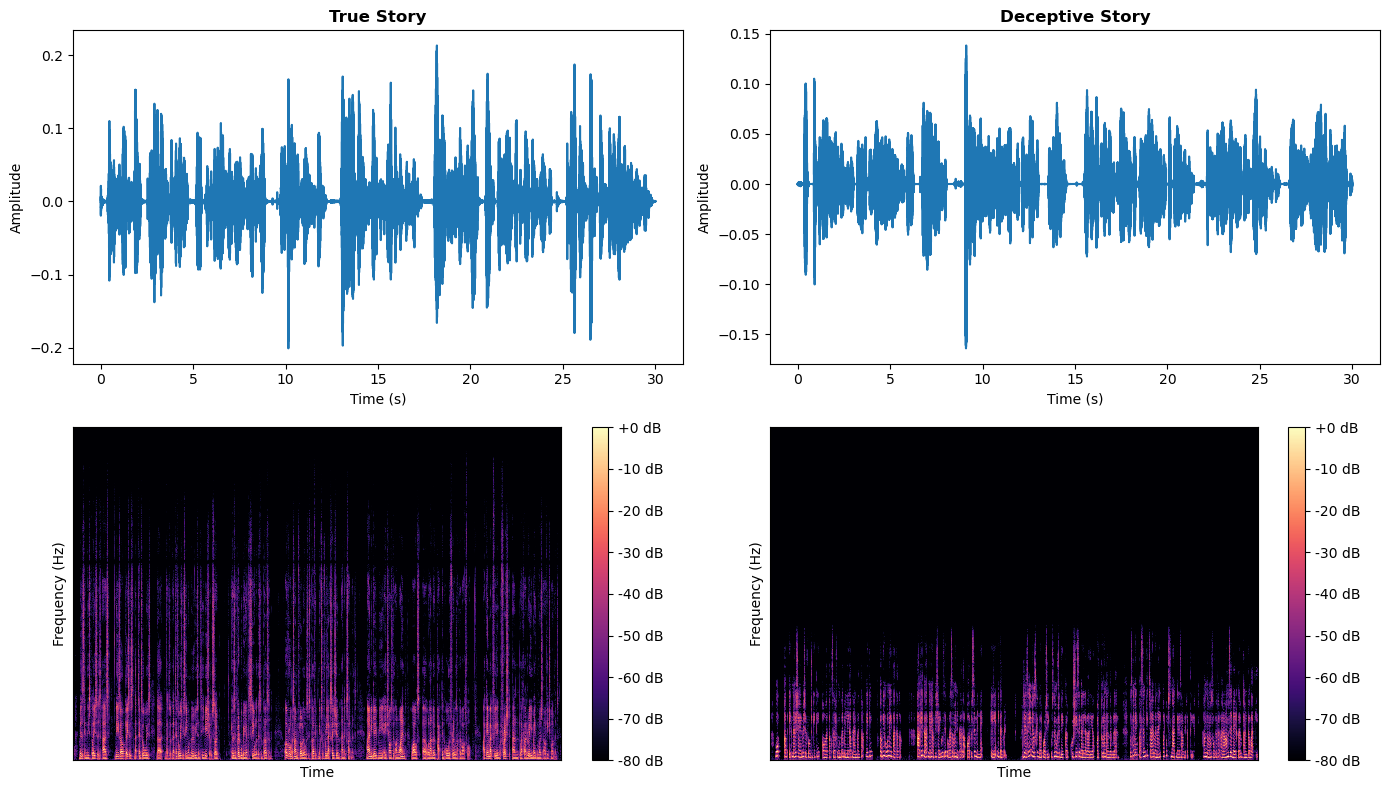

In [4]:
def time_freq_viz(X1, y1, X2, y2, sampling_rate):
    fig, ax = plt.subplots(2, 2, figsize=(14, 8))
    ax[0, 0].plot(np.arange(len(X1)) / sampling_rate, X1)
    ax[0, 0].set_ylabel('Amplitude')
    ax[0, 0].set_xlabel('Time (s)')
    ax[0, 0].set_title('Deceptive Story' if y1 == 1 else 'True Story', fontweight='bold')

    spec = librosa.amplitude_to_db(np.abs(librosa.stft(X1)), ref=np.max)
    img = librosa.display.specshow(spec, sr=sampling_rate, ax=ax[1, 0])
    fig.colorbar(img, format='%+2.f dB', ax=ax[1, 0])
    ax[1, 0].set_ylabel('Frequency (Hz)')
    ax[1, 0].set_xlabel('Time')

    ax[0, 1].plot(np.arange(len(X2)) / sampling_rate, X2)
    ax[0, 1].set_ylabel('Amplitude')
    ax[0, 1].set_xlabel('Time (s)')
    ax[0, 1].set_title('Deceptive Story' if y2 == 1 else 'True Story', fontweight='bold')

    spec = librosa.amplitude_to_db(np.abs(librosa.stft(X2)), ref=np.max)
    img = librosa.display.specshow(spec, sr=sampling_rate, ax=ax[1, 1])
    fig.colorbar(img, format='%+2.f dB', ax=ax[1, 1])
    ax[1, 1].set_ylabel('Frequency (Hz)')
    ax[1, 1].set_xlabel('Time')

    plt.tight_layout()
    return plt.show()

time_freq_viz(audio_series[4], label[4], audio_series[0], label[0], 44100)

## 5.2 Feature Datasets
Up to this point, the augmented dataset has been created. Each sample is a unique 30 second audio time series with several augmentations, saved as a Numpy array. The final step before the model stage is creating the feature datasets.

Three datasets are created here, each focusing on a slightly different subset of features defined in section 4.1. The first dataset contains the four attributes found in the starter kit: Power, Pitch Mean, Pitch Standard Deviation, and Fraction Voiced. This is to assess a baseline performance and compare how well this dataset performs compared to the other two. The second dataset contains the Pitch Mean, Pitch Standard Deviation, Fraction Voiced, Root Mean Square Energy, and Zero-Crossing Rate. This dataset was identified to focus on the time domain, substituting the Power attribute for the Root Mean Square Energy attribute, as both are fairly similar and highly correlated. As for the final dataset, it contains the features Power, Pitch Mean, Pitch Standard Deviation, Fraction Voiced, Spectral Centroid, and Spectral Bandwidth. The motivation behind this dataset was to include an element of the frequency-domain.

The prediction pipeline previously defined will be run on each of these three datasets to see how the selected features impact performance.

In [ ]:
def feature_extraction(audio_series, sampling_rate, scale_audio=True):

    X1, X2, X3 = [], [], []
    for audio_series in audio_series:
        if scale_audio: audio_series = audio_series / np.max(np.abs(audio_series))

        power = np.sum(audio_series ** 2) / len(audio_series)

        pitch, voiced_flag, _ = librosa.pyin(y=audio_series, fmin=80, fmax=450, sr=sampling_rate, frame_length=1024, hop_length=1024 // 2)
        pitch_mean = np.nanmean(pitch) if np.mean(np.isnan(pitch)) < 1 else 0
        pitch_std = np.nanstd(pitch) if np.mean(np.isnan(pitch)) < 1 else 0
        voiced_frac = np.mean(voiced_flag)

        rmse_energy_mean = np.mean(librosa.feature.rms(y=audio_series, frame_length=1024, hop_length=1024 // 2).flatten())
        zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y=audio_series, frame_length=1024, hop_length=1024 // 2).flatten())

        spec_cent_mean = np.mean(librosa.feature.spectral_centroid(y=audio_series, n_fft=1024, hop_length=1024 // 2).flatten())
        spec_band_mean = np.mean(librosa.feature.spectral_bandwidth(y=audio_series, n_fft=1024, hop_length=1024 // 2).flatten())

        X1.append([power, pitch_mean, pitch_std, voiced_frac])
        X2.append([pitch_mean, pitch_std, voiced_frac, rmse_energy_mean, zcr_mean])
        X3.append([power, pitch_mean, pitch_std, voiced_frac, spec_cent_mean, spec_band_mean])

    return np.array(X1), np.array(X2), np.array(X3)

# Uncomment and run below if features haven't been extracted and saved locally -> May take a long time
# X1, X2, X3 = feature_extraction(audio_series, 44100)
# np.save(os.path.join('MLEnd', 'deception', 'X1.npy'), X1)
# np.save(os.path.join('MLEnd', 'deception', 'X2.npy'), X2)
# np.save(os.path.join('MLEnd', 'deception', 'X3.npy'), X3)
# np.save(os.path.join('MLEnd', 'deception', 'y.npy'), label)

The distributions of all the identified variables appear somewhat similar. The most notable differences are the medians across classes for Pitch Standard Deviation and Fraction Voiced, as well as the interquartile range for Pitch Mean. This may indicate that the chosen variables were not the most appropriate as more clear trends between deceptive and truthful stories would likely result in better model performance. However, these initial observations will be explored further during the model training stage.

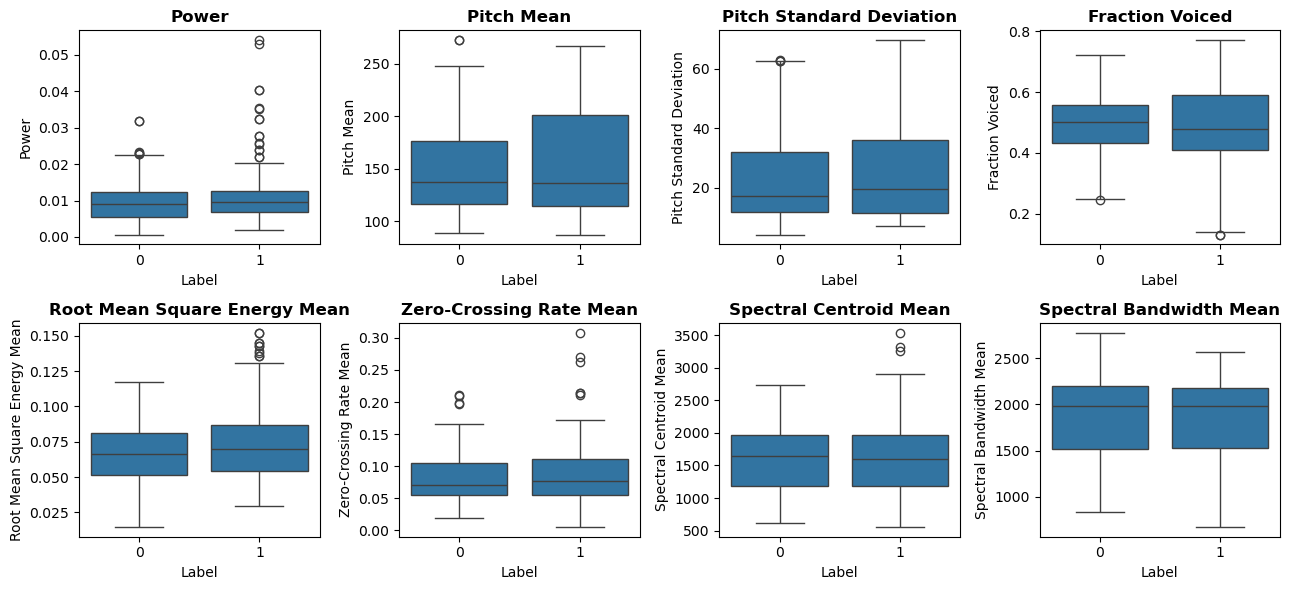

In [6]:
X1 = np.load(os.path.join('MLEnd', 'deception', 'X1.npy'))
X2 = np.load(os.path.join('MLEnd', 'deception', 'X2.npy'))
X3 = np.load(os.path.join('MLEnd', 'deception', 'X3.npy'))
y = np.load(os.path.join('MLEnd', 'deception', 'y.npy'))

unique_predictors = pd.DataFrame([[x1[0], x1[1], x1[2], x1[3], x2[3], x2[4], x3[4], x3[5], y] for x1, x2, x3, y in zip(X1, X2, X3, y)],
                                 columns=['Power', 'Pitch Mean', 'Pitch Standard Deviation', 'Fraction Voiced', 'Root Mean Square Energy Mean',
                                          'Zero-Crossing Rate Mean', 'Spectral Centroid Mean', 'Spectral Bandwidth Mean', 'Label'])

fig, ax = plt.subplots(2, 4, figsize=(13, 6))

predictor_cols = [col for col in unique_predictors.columns if col != 'Label']
for col, ax in zip(predictor_cols, ax.flat):
    sns.boxplot(data=unique_predictors, y=col, x='Label', ax=ax)
    ax.set_title(col, fontweight='bold')

plt.tight_layout()
plt.show()

# 6 Experiments and results
## 6.1 Baseline (Starter-kit) Dataset
The previous section created three Numpy arrays corresponding to the three sets of predictors. This first section explores the baseline dataset involving the starter-kit attributes. Before any models are explored, the dataset is split into a training, validation, test set according to the following distribution: 75 train / 10 val / 15 test. Class balance was also maintained using the stratify parameter within the train_test_split function of Scikit-Learn.

In [7]:
print('Dataset 1: Baseline (Starter-kit)\n')
X_remaining, X_test, y_remaining, y_test = train_test_split(X1, y, test_size=0.15, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=0.1167, random_state=0, stratify=y_remaining)

print(f'Test Class Balance: {sum(y for y in y_test if y == 1) / len(y_test):.2%}')
print(f'Validation Class Balance: {sum(y for y in y_val if y == 1) / len(y_val):.2%}')
print(f'Train Class Balance: {sum(y for y in y_train if y == 1) / len(y_train):.2%}')

Dataset 1: Baseline (Starter-kit)

Test Class Balance: 50.00%
Validation Class Balance: 50.00%
Train Class Balance: 50.00%


The Random Forest Classifier definitely appears to be overfitting given how high the training accuracies are. This could potentially be due to some regularization parameters I have not included. As such, this particular model's results may not be that generalisable, although the validation accuracy in itself is not that bad. There was also not much improvement in the validation accuracy as a result of standardisation. This is likely due to the algorithm not relying heavily on the scale of the attributes. 

As for the SVM, performance definitely improved after standardising and optimising. Different kernels were also tried with the radial basis function being the best performer, perhaps indicating that the data is not linearly separable.

Regarding the kNN, only training accuracy saw the largest improvement as a result of standardisation and hyperparameter tuning. As the validation accuracy did not increase, this likely means that the adjustments to the model do not make any substantial improvements for unseen data.

Fortunately, all the classifiers have a validation accuracy of greater than a 50/50 chance. When combinining the training and validation sets and using this to train the ensemble model, test accuracy actually sees a fairly large improvement over the individual validation accuracies. This is a good sign although further testing is likely needed on an even larger and independent test dataset to verify these results.

In [8]:
print('\nRandom Forest Classifier')
rfc = RandomForestClassifier(oob_score=True, random_state=0)
rfc.fit(X_train, y_train)
print(f'Training Accuracy: {rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {rfc.score(X_val, y_val)}')

print('\nStandardised Random Forest Classifier')
stand_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(oob_score=True, random_state=0))])
stand_rfc.fit(X_train, y_train)
print(f'Training Accuracy: {stand_rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_rfc.score(X_val, y_val)}')

print('\nOptimised Standardised Random Forest Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(oob_score=True, random_state=0))])
param_grid = {'rfc__n_estimators':[100, 200, 300, 400, 500],
              'rfc__max_depth':[6, 7, 8, 9],
              'rfc__max_leaf_nodes':[10, 20, 50, 100, 200]}
tuned_stand_rfc = GridSearchCV(pipe, param_grid)
tuned_stand_rfc.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_rfc.best_params_}')
print(f'Training Accuracy: {tuned_stand_rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_rfc.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nSupport Vector Machine Classifier')
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
print(f'Training Accuracy: {svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {svm.score(X_val, y_val)}')

print('\nStandardised SVM Classifier')
stand_svm = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])
stand_svm.fit(X_train, y_train)
print(f'Training Accuracy: {stand_svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_svm.score(X_val, y_val)}')

print('\nOptimised Standardised SVM Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])
param_grid = {'svc__C':[9, 10, 11, 12],
              'svc__gamma':[1, 2, 3]}
tuned_stand_svm = GridSearchCV(pipe, param_grid)
tuned_stand_svm.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_svm.best_params_}')
print(f'Training Accuracy: {tuned_stand_svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_svm.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nkNN Classifier')
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'Training Accuracy: {knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {knn.score(X_val, y_val)}')

print('\nStandardised kNN Classifier')
stand_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
stand_knn.fit(X_train, y_train)
print(f'Training Accuracy: {stand_knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_knn.score(X_val, y_val)}')

print('\nOptimised Standardised kNN Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
tuned_stand_knn = GridSearchCV(pipe, param_grid)
tuned_stand_knn.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_knn.best_params_}')
print(f'Training Accuracy: {tuned_stand_knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_knn.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nEnsemble Model - Hard Voting')
rfc_bestparams = {key.replace('rfc__',''):value for key, value in tuned_stand_rfc.best_params_.items()}
knn_bestparams = {key.replace('knn__',''):value for key, value in tuned_stand_knn.best_params_.items()}
svm_bestparams = {key.replace('svc__',''):value for key, value in tuned_stand_svm.best_params_.items()}

pipe_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(**rfc_bestparams, oob_score=True, random_state=0))])
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(**knn_bestparams))])
pipe_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(**svm_bestparams, kernel='rbf'))])

X_train, y_train = np.vstack([X_train, X_val]), np.vstack([np.reshape(y_train, (len(y_train), 1)), np.reshape(y_val, (len(y_val), 1))]).ravel()

ensemble1 = VotingClassifier(estimators=[('rfc', pipe_rfc), ('knn', pipe_knn), ('svm', pipe_svm)], voting='hard')
ensemble1.fit(X_train, y_train)
print(f'Ensemble Training Accuracy: {ensemble1.score(X_train, y_train)}')
print(f'Ensemble Test Accuracy: {ensemble1.score(X_test, y_test)}')

X1_test = np.copy(X_test)


Random Forest Classifier
Training Accuracy: 1.0
Validation Accuracy: 0.775

Standardised Random Forest Classifier
Training Accuracy: 1.0
Validation Accuracy: 0.75

Optimised Standardised Random Forest Classifier
Optimised Hyperparameters:{'rfc__max_depth': 8, 'rfc__max_leaf_nodes': 50, 'rfc__n_estimators': 100}
Training Accuracy: 0.99
Validation Accuracy: 0.775
------------------------------------------------------------------------------------------------------------

Support Vector Machine Classifier
Training Accuracy: 0.5466666666666666
Validation Accuracy: 0.525

Standardised SVM Classifier
Training Accuracy: 0.72
Validation Accuracy: 0.55

Optimised Standardised SVM Classifier
Optimised Hyperparameters:{'svc__C': 9, 'svc__gamma': 2}
Training Accuracy: 0.9766666666666667
Validation Accuracy: 0.825
------------------------------------------------------------------------------------------------------------

kNN Classifier
Training Accuracy: 0.7966666666666666
Validation Accuracy: 0.

## 6.2 Time-Domain Dataset
This second dataset replaces the power attribute found in the starter kit with the Root Mean Square Energy and includes a new attribute, Zero-Crossing Rate. The main goal of using this dataset is to compare the performance of using slightly different time-domain features to the original base dataset. As before, the training, validation, and test datasets are split in the same ratio and the class balance is maintained using stratification.

In [9]:
print('Dataset 2: Tme-Domain\n')
X_remaining, X_test, y_remaining, y_test = train_test_split(X2, y, test_size=0.15, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=0.1167, random_state=0, stratify=y_remaining)

print(f'Test Class Balance: {sum(y for y in y_test if y == 1) / len(y_test):.2%}')
print(f'Validation Class Balance: {sum(y for y in y_val if y == 1) / len(y_val):.2%}')
print(f'Train Class Balance: {sum(y for y in y_train if y == 1) / len(y_train):.2%}')

Dataset 2: Tme-Domain

Test Class Balance: 50.00%
Validation Class Balance: 50.00%
Train Class Balance: 50.00%


The results from the machine learning pipeline using this dataset are almost identical to the baseline dataset. This is likely due to the feature selection as the Root Mean Square Error is highly correlated with the Power attribute used in the baseline dataset. The results of this section could then be seen as reaffirming the results of the previous section. In order to truly assess the impact of other time-domain features, more diverse features would likely need to be chosen. Perhaps also by removing the other baseline variables, a clearer impact can be established.

In [10]:
print('\nRandom Forest Classifier')
rfc = RandomForestClassifier(oob_score=True, random_state=0)
rfc.fit(X_train, y_train)
print(f'Training Accuracy: {rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {rfc.score(X_val, y_val)}')

print('\nStandardised Random Forest Classifier')
stand_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(oob_score=True, random_state=0))])
stand_rfc.fit(X_train, y_train)
print(f'Training Accuracy: {stand_rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_rfc.score(X_val, y_val)}')

print('\nOptimised Standardised Random Forest Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(oob_score=True, random_state=0))])
param_grid = {'rfc__n_estimators':[100, 200, 300, 400, 500],
              'rfc__max_depth':[6, 7, 8, 9],
              'rfc__max_leaf_nodes':[10, 20, 50, 100, 200]}
tuned_stand_rfc = GridSearchCV(pipe, param_grid)
tuned_stand_rfc.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_rfc.best_params_}')
print(f'Training Accuracy: {tuned_stand_rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_rfc.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nSupport Vector Machine Classifier')
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
print(f'Training Accuracy: {svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {svm.score(X_val, y_val)}')

print('\nStandardised SVM Classifier')
stand_svm = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])
stand_svm.fit(X_train, y_train)
print(f'Training Accuracy: {stand_svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_svm.score(X_val, y_val)}')

print('\nOptimised Standardised SVM Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])
param_grid = {'svc__C':[9, 10, 11, 12],
              'svc__gamma':[1, 2, 3]}
tuned_stand_svm = GridSearchCV(pipe, param_grid)
tuned_stand_svm.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_svm.best_params_}')
print(f'Training Accuracy: {tuned_stand_svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_svm.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nkNN Classifier')
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'Training Accuracy: {knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {knn.score(X_val, y_val)}')

print('\nStandardised kNN Classifier')
stand_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
stand_knn.fit(X_train, y_train)
print(f'Training Accuracy: {stand_knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_knn.score(X_val, y_val)}')

print('\nOptimised Standardised kNN Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
tuned_stand_knn = GridSearchCV(pipe, param_grid)
tuned_stand_knn.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_knn.best_params_}')
print(f'Training Accuracy: {tuned_stand_knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_knn.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nEnsemble Model - Hard Voting')
rfc_bestparams = {key.replace('rfc__',''):value for key, value in tuned_stand_rfc.best_params_.items()}
knn_bestparams = {key.replace('knn__',''):value for key, value in tuned_stand_knn.best_params_.items()}
svm_bestparams = {key.replace('svc__',''):value for key, value in tuned_stand_svm.best_params_.items()}

pipe_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(**rfc_bestparams, oob_score=True, random_state=0))])
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(**knn_bestparams))])
pipe_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(**svm_bestparams, kernel='rbf'))])

X_train, y_train = np.vstack([X_train, X_val]), np.vstack([np.reshape(y_train, (len(y_train), 1)), np.reshape(y_val, (len(y_val), 1))]).ravel()

ensemble2 = VotingClassifier(estimators=[('rfc', pipe_rfc), ('knn', pipe_knn), ('svm', pipe_svm)], voting='hard')
ensemble2.fit(X_train, y_train)
print(f'Ensemble Training Accuracy: {ensemble2.score(X_train, y_train)}')
print(f'Ensemble Test Accuracy: {ensemble2.score(X_test, y_test)}')

X2_test = np.copy(X_test)


Random Forest Classifier
Training Accuracy: 1.0
Validation Accuracy: 0.775

Standardised Random Forest Classifier
Training Accuracy: 1.0
Validation Accuracy: 0.775

Optimised Standardised Random Forest Classifier
Optimised Hyperparameters:{'rfc__max_depth': 9, 'rfc__max_leaf_nodes': 50, 'rfc__n_estimators': 300}
Training Accuracy: 1.0
Validation Accuracy: 0.775
------------------------------------------------------------------------------------------------------------

Support Vector Machine Classifier
Training Accuracy: 0.5466666666666666
Validation Accuracy: 0.525

Standardised SVM Classifier
Training Accuracy: 0.74
Validation Accuracy: 0.6

Optimised Standardised SVM Classifier
Optimised Hyperparameters:{'svc__C': 9, 'svc__gamma': 2}
Training Accuracy: 0.9933333333333333
Validation Accuracy: 0.8
------------------------------------------------------------------------------------------------------------

kNN Classifier
Training Accuracy: 0.7966666666666666
Validation Accuracy: 0.575

## 6.3 Baseline + Frequency-Domain
This dataset takes the initial baseline dataset and adds a couple spectral attributes from the frequency-domain. The dataset is partitioned into training, validation, and testing in the same way and stratified as well.

In [11]:
print('Dataset 3: Baseline + Frequency-Domain\n')
X_remaining, X_test, y_remaining, y_test = train_test_split(X3, y, test_size=0.15, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=0.1167, random_state=0, stratify=y_remaining)

print(f'Test Class Balance: {sum(y for y in y_test if y == 1) / len(y_test):.2%}')
print(f'Validation Class Balance: {sum(y for y in y_val if y == 1) / len(y_val):.2%}')
print(f'Train Class Balance: {sum(y for y in y_train if y == 1) / len(y_train):.2%}')

Dataset 3: Baseline + Frequency-Domain

Test Class Balance: 50.00%
Validation Class Balance: 50.00%
Train Class Balance: 50.00%


There is a clear decrease in validation accuracy across the board for the individual models and the ensemble models. Given this, it's likely that the features selected for the task are not appropriate. This could be due to too many features (there are 6 in total, the most out of all the datasets) or the fact that the chosen additional attributes are spectral. Further investigation is likely needed to assess whether alternative spectral features could enhance performance.

In [12]:
print('\nRandom Forest Classifier')
rfc = RandomForestClassifier(oob_score=True, random_state=0)
rfc.fit(X_train, y_train)
print(f'Training Accuracy: {rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {rfc.score(X_val, y_val)}')

print('\nStandardised Random Forest Classifier')
stand_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(oob_score=True, random_state=0))])
stand_rfc.fit(X_train, y_train)
print(f'Training Accuracy: {stand_rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_rfc.score(X_val, y_val)}')

print('\nOptimised Standardised Random Forest Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(oob_score=True, random_state=0))])
param_grid = {'rfc__n_estimators':[100, 200, 300, 400, 500],
              'rfc__max_depth':[6, 7, 8, 9],
              'rfc__max_leaf_nodes':[10, 20, 50, 100, 200]}
tuned_stand_rfc = GridSearchCV(pipe, param_grid)
tuned_stand_rfc.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_rfc.best_params_}')
print(f'Training Accuracy: {tuned_stand_rfc.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_rfc.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nSupport Vector Machine Classifier')
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
print(f'Training Accuracy: {svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {svm.score(X_val, y_val)}')

print('\nStandardised SVM Classifier')
stand_svm = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])
stand_svm.fit(X_train, y_train)
print(f'Training Accuracy: {stand_svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_svm.score(X_val, y_val)}')

print('\nOptimised Standardised SVM Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])
param_grid = {'svc__C':[9, 10, 11, 12],
              'svc__gamma':[1, 2, 3]}
tuned_stand_svm = GridSearchCV(pipe, param_grid)
tuned_stand_svm.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_svm.best_params_}')
print(f'Training Accuracy: {tuned_stand_svm.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_svm.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nkNN Classifier')
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'Training Accuracy: {knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {knn.score(X_val, y_val)}')

print('\nStandardised kNN Classifier')
stand_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
stand_knn.fit(X_train, y_train)
print(f'Training Accuracy: {stand_knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {stand_knn.score(X_val, y_val)}')

print('\nOptimised Standardised kNN Classifier')
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
tuned_stand_knn = GridSearchCV(pipe, param_grid)
tuned_stand_knn.fit(X_train, y_train)
print(f'Optimised Hyperparameters:{tuned_stand_knn.best_params_}')
print(f'Training Accuracy: {tuned_stand_knn.score(X_train, y_train)}')
print(f'Validation Accuracy: {tuned_stand_knn.score(X_val, y_val)}')

print('------------------------------------------------------------------------------------------------------------')

print('\nEnsemble Model - Hard Voting')
rfc_bestparams = {key.replace('rfc__',''):value for key, value in tuned_stand_rfc.best_params_.items()}
knn_bestparams = {key.replace('knn__',''):value for key, value in tuned_stand_knn.best_params_.items()}
svm_bestparams = {key.replace('svc__',''):value for key, value in tuned_stand_svm.best_params_.items()}

pipe_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(**rfc_bestparams, oob_score=True, random_state=0))])
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(**knn_bestparams))])
pipe_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(**svm_bestparams, kernel='rbf'))])

X_train, y_train = np.vstack([X_train, X_val]), np.vstack([np.reshape(y_train, (len(y_train), 1)), np.reshape(y_val, (len(y_val), 1))]).ravel()

ensemble3 = VotingClassifier(estimators=[('rfc', pipe_rfc), ('knn', pipe_knn), ('svm', pipe_svm)], voting='hard')
ensemble3.fit(X_train, y_train)
print(f'Ensemble Training Accuracy: {ensemble3.score(X_train, y_train)}')
print(f'Ensemble Test Accuracy: {ensemble3.score(X_test, y_test)}')

X3_test = np.copy(X_test)


Random Forest Classifier
Training Accuracy: 1.0
Validation Accuracy: 0.675

Standardised Random Forest Classifier
Training Accuracy: 1.0
Validation Accuracy: 0.675

Optimised Standardised Random Forest Classifier
Optimised Hyperparameters:{'rfc__max_depth': 9, 'rfc__max_leaf_nodes': 50, 'rfc__n_estimators': 400}
Training Accuracy: 1.0
Validation Accuracy: 0.725
------------------------------------------------------------------------------------------------------------

Support Vector Machine Classifier
Training Accuracy: 0.51
Validation Accuracy: 0.525

Standardised SVM Classifier
Training Accuracy: 0.75
Validation Accuracy: 0.7

Optimised Standardised SVM Classifier
Optimised Hyperparameters:{'svc__C': 10, 'svc__gamma': 2}
Training Accuracy: 0.9966666666666667
Validation Accuracy: 0.725
------------------------------------------------------------------------------------------------------------

kNN Classifier
Training Accuracy: 0.76
Validation Accuracy: 0.7

Standardised kNN Classifi

# 7 Conclusions
Confusion matrices are shown below for the predicted models as a result of the ensemble models across each of the three datasets. The ensemble models trained on the first two datasets predicted exactly the same number of labels correctly and incorrectly. The ensemble model trained on dataset three, however, performed worse than the other two datasets, predicting 4 additional false positives and 2 additional false negatives.

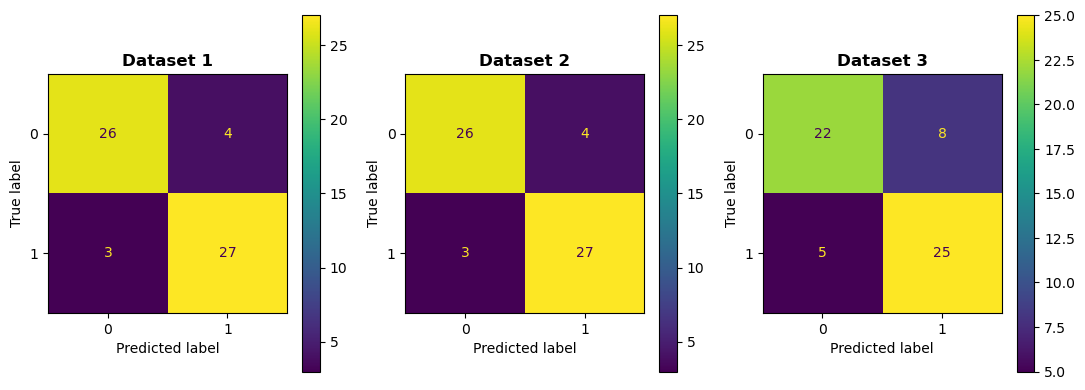

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))

ax[0].set_title('Dataset 1', fontweight='bold')
ConfusionMatrixDisplay.from_predictions(y_test, ensemble1.predict(X1_test), ax=ax[0])

ax[1].set_title('Dataset 2', fontweight='bold')
ConfusionMatrixDisplay.from_predictions(y_test, ensemble2.predict(X2_test), ax=ax[1])

ax[2].set_title('Dataset 3', fontweight='bold')
ConfusionMatrixDisplay.from_predictions(y_test, ensemble3.predict(X3_test), ax=ax[2])

plt.tight_layout()
plt.show()

There are several things this mini-project can improve on. First, and most importantly, is the feature selection. Adding additional attributes resulted in the same or worse performance across models. This may be due to the curse of dimensionality and could be resolved by being more selective with the features. Perhaps instead of adding new features, the original four attributes could be completely changed so as to keep the same number of attributes but test a different set.

Secondly, there is much room for adjustment and additional augmentation during the initial dataset creation phase. The dataset could be extended even further through additional augmentation techniques, making the sample set larger than the 400 created here. There are also various augmentation parameters which could be adjusted to make more varied and diverse datasets, possibly leading to more robust machine learning results.

During the feature extraction phase, there are also some parameters which could be tuned. For example, the frame length and hop length for the various extracted features could be adjusted, changing the resolution of the resulting audio series. These could lead to different model performance, the extent of which could be studied through experimentation.

As for the model training & tuning phase, there were some improvements there in regards to over-fitting. The Random Forest Classifier, for example, is clearly overfitting with a training accuracy of 100%. Further improvements could be made by studying the regularisation parameters and testing these out. There are also some potential improvements in the method of the hyperparameter tuning. As the grid search is computationally expensive, only a limited range of hyperparameters were searched. An alternative tuning method of using random search and then grid search could yield more optimal hyperparameters and open the door to optimising more hyperparameters than the current setup allowed.

Lastly, two potential options to explore are additional ensemble methods and additional standardisation options. While changing these two points may not necessarily yield a significant difference in results, it would be good to experiment with differing combinations to find the best combination for the task of classifying audio stories.

# 8 References

https://www.youtube.com/playlist?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0

https://www.youtube.com/watch?v=I2T3OYNqhyA

https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53#:~:text=In%20Summary,to%20form%20the%20mel%20spectrogram.

https://www.youtube.com/watch?v=umAXGVzVvwQ

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1#:~:text=max_depth%3A%20The%20number%20of%20splits,shown%20to%20each%20decision%20tree.